In [1]:
#import libraries
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from yahoo_fin import stock_info

In [2]:
#Import data
tcsweekly = stock_info.get_data("TCS.NS", interval="1wk")
tcsweekly = tcsweekly.drop(['ticker'], axis=1)
tcsweekly=tcsweekly.dropna() #Remove Null Values
tcsweekly

,open,high,low,close,adjclose,volume
2002-08-11,38.724998,40.387501,35.724998,36.375000,26.099295,2001184.0
2002-08-18,36.674999,43.625000,35.137501,42.299999,30.350506,18564720.0
2002-08-25,42.974998,45.125000,40.287498,44.049999,31.606155,12945024.0
2002-09-01,44.750000,45.974998,41.012501,41.474998,29.758566,6795040.0
2002-09-08,39.500000,43.224998,39.500000,40.987499,29.408785,2637016.0
...,...,...,...,...,...,...
2023-04-02,3224.949951,3264.350098,3173.750000,3220.699951,3220.699951,5880359.0
2023-04-09,3220.000000,3272.949951,3180.000000,3188.850098,3188.850098,11143763.0
2023-04-16,3134.100098,3164.449951,3070.250000,3160.850098,3160.850098,15769567.0
2023-04-23,3151.100098,3227.250000,3126.149902,3219.250000,3219.250000,11030553.0


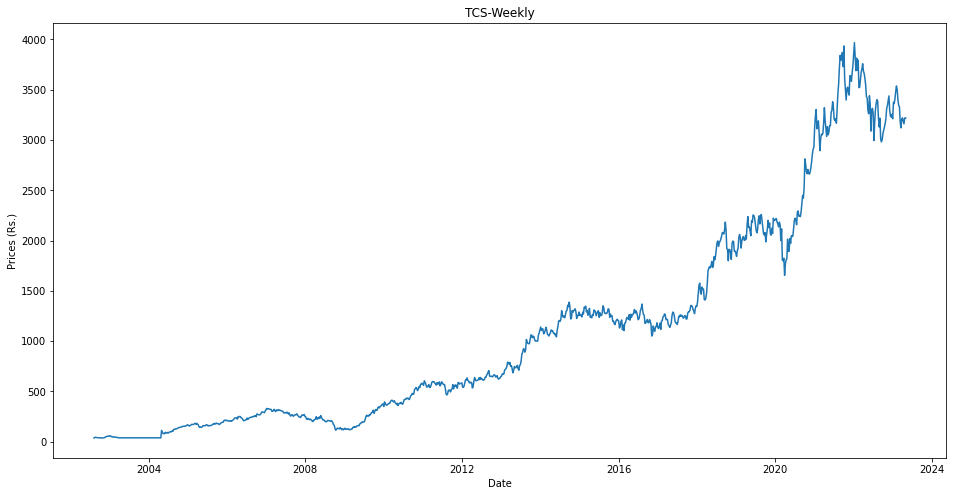

In [3]:
#Plot the graph
plt.figure(figsize=(16,8))
plt.plot(tcsweekly['close'])
plt.title('TCS-Weekly')
plt.xlabel('Date')
plt.ylabel('Prices (Rs.)')
plt.show()

In [4]:
#Take close price and it's value
close_prices = tcsweekly['close'] 
values = close_prices.values

#Print
print(len(values))
print(values[0:10])

1082
[36.375      42.29999924 44.04999924 41.47499847 40.98749924 39.09999847
 38.47499847 37.51250076 38.21250153 38.8125    ]


In [5]:
#take 80% of the data for training
training_data_len = math.ceil(len(values)*0.8) 
print(training_data_len)

866


In [6]:
#Scale the data for easy computation
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

#Select training data from 0 to length
train_data = scaled_data[0: training_data_len, :]

#Print
print(train_data[0:10])

[[0.        ]
 [0.00150695]
 [0.00195204]
 [0.00129712]
 [0.00117313]
 [0.00069307]
 [0.00053411]
 [0.00028931]
 [0.00046735]
 [0.00061995]]


In [8]:
x_train = []
y_train = []

#Create a list of 60 values in a single input of x_train and then the take the 61st value in y
#Here 60 is arbitrary and any other number can be taken
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0]) #Take 0-60 values of train_data for Predictor
    y_train.append(train_data[i, 0]) #Take 61st value of train_data for Output
    
#Convert to Array and reshape the values
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Print check some stuff
print(len(x_train))
print(len(y_train))
print(len(x_train[0]))
print(len(x_train[1]))
print(x_train[0][0:10])

806
806
60
60
[[0.        ]
 [0.00150695]
 [0.00195204]
 [0.00129712]
 [0.00117313]
 [0.00069307]
 [0.00053411]
 [0.00028931]
 [0.00046735]
 [0.00061995]]


In [8]:
#Define the model
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

#Train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=50, epochs=10)

2023-04-04 13:22:20.527705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
17/17 [==============================] - 13s 247ms/step - loss: 0.0069
Epoch 2/10
17/17 [==============================] - 4s 241ms/step - loss: 7.1493e-04
Epoch 3/10
17/1

In [9]:
#Scale the test data for prediction
test_data = scaled_data[training_data_len-60: , : ] #

x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Print
print(x_test.shape[1])
print(len(x_test))
print(len(y_test))
len(x_test[0])

60
215
215


60

In [10]:
#Predict for the set of 60 values
predictions_old = model.predict(x_test)
predictions = scaler.inverse_transform(predictions_old)

#Print
print(len(predictions))
print(predictions[-1])
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 [==============================] - 5s 66ms/step
215
[3356.756]


8.008347906068314

/var/folders/_m/7wdfvnkn1871d5q_fgf9lqj00000gn/T/ipykernel_1148/2289823899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


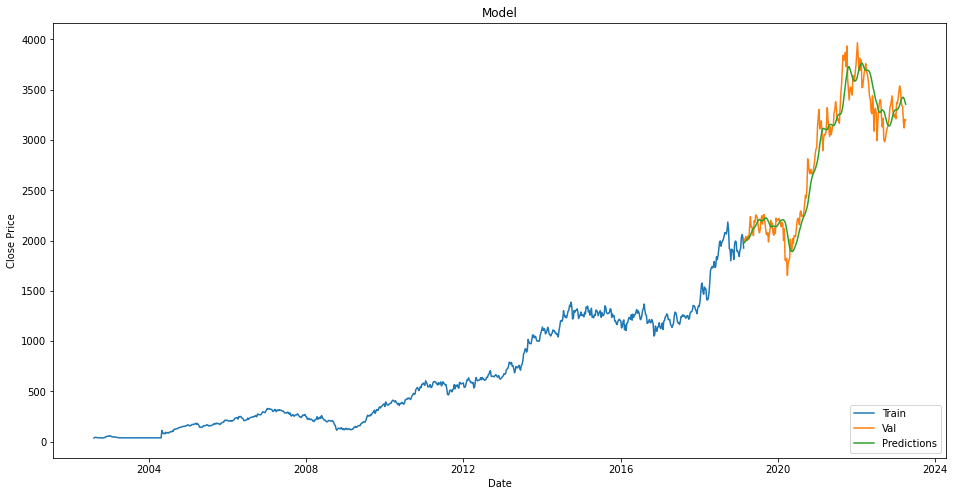

In [11]:
#Preprocess
data = tcsweekly.filter(['close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions

#Print the Graph
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
import joblib
joblib.dump(model, 'tcsdail_1.pkl')

In [ ]:
# Load the model from the file
new = joblib.load('tcsdail_1.pkl')
  
# Use the loaded model to make predictions
ans = new.predict(x_test)
ans

In [13]:
result = predictions.flatten()

#R2 Score
from sklearn.metrics import r2_score
score = r2_score(y_test, result)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

from sklearn.metrics import mean_absolute_error
score_1 = mean_absolute_error(y_test, result)
print("The Mean Absolute Error of our Model is {}".format(round(score_1, 2)))

from sklearn.metrics import mean_squared_error
import numpy as np
score_2 = np.sqrt(mean_squared_error(y_test, result))
print("The Root Mean Square Error of our Model is {}".format(round(score_2, 2)))

new_result = scaler.fit_transform(result.reshape(-1,1))
new_actual = scaler.fit_transform(y_test.reshape(-1,1))
new_actual

#R2 Score
from sklearn.metrics import r2_score
score = r2_score(new_actual, new_result)
print("The accuracy of our model is {}%".format(round(score, 2) *100))

from sklearn.metrics import mean_absolute_error
score_1 = mean_absolute_error(new_actual, new_result)
print("The Mean Absolute Error of our Model is {}".format(round(score_1, 2)))

from sklearn.metrics import mean_squared_error
import numpy as np
score_2 = np.sqrt(mean_squared_error(new_actual, new_result))
print("The Root Mean Square Error of our Model is {}".format(round(score_2, 2)))

The accuracy of our model is 93.0%
The Mean Absolute Error of our Model is 127.27
The Root Mean Square Error of our Model is 164.88
The accuracy of our model is 86.0%
The Mean Absolute Error of our Model is 0.09
The Root Mean Square Error of our Model is 0.1
